## 1) Creating Fake Web Log Data

**There isn't enough data available online, so I generated my own synthetic web traffic log data using Python.**

In [1]:
pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.3 MB/s eta 0:00:00:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import time
from faker import Faker

fake = Faker()

# Determine Apache log format
log_format = '{ip} - - [{timestamp}] "{method} {url} HTTP/1.1" {status} {size}'

# Random URL list
urls = [
    '/home',
    '/about',
    '/contact',
    '/products',
    '/products/item?id=1',
    '/products/item?id=2',
    '/search?q=test',
    '/login',
    '/signup',
]

methods = ['GET', 'POST', 'PUT', 'DELETE']

# HTTP State Code
status_codes = [200, 301, 404, 500]

# Weight for methods and status codes 
method_weights = [0.5, 0.3, 0.1, 0.1]  
status_weights = [0.6, 0.2, 0.1, 0.1]  

def generate_ip():
    return fake.ipv4()

def generate_log_line():
    ip = generate_ip()
    timestamp = time.strftime('%d/%b/%Y:%H:%M:%S +0000', time.gmtime(fake.unix_time()))
    method = random.choices(methods, weights=method_weights)[0]  
    url = random.choice(urls)
    status = random.choices(status_codes, weights=status_weights)[0]  
    size = random.randint(200, 5000)
    
    return log_format.format(ip=ip, timestamp=timestamp, method=method, url=url, status=status, size=size)

def generate_log_file(filename, num_lines=10000):
    with open(filename, 'w') as f:
        for _ in range(num_lines):
            f.write(generate_log_line() + '\n')

generate_log_file('final_web_traffic.log', num_lines=9000)

print("Log file created successfully.")


Log file created successfully.


## 2) Converting LOGS data to DF for easier data processing and analysis:

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)  
pd.set_option('display.max_rows', None) 

In [5]:
log_file_path ='/kaggle/working/final_web_traffic.log'
# regex 
log_pattern = r'(?P<ip>\d+\.\d+\.\d+\.\d+) - - \[(?P<timestamp>[^\]]+)\] "(?P<method>[A-Z]+) (?P<url>[^\s]+) HTTP/1\.1" (?P<status>\d+) (?P<size>\d+)'


def parse_log_line(line):
    match = re.match(log_pattern, line)
    if match:
        return match.groupdict()
    return None

def log_to_dataframe(file_path):
    try:
        with open(file_path, 'r') as file:
            log_lines = file.readlines()

        parsed_logs = [parse_log_line(line) for line in log_lines if parse_log_line(line) is not None]
        
        return pd.DataFrame(parsed_logs)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return pd.DataFrame() 

# Creating DF
logs_df = log_to_dataframe(log_file_path)


In [6]:
logs_df.head()

,ip,timestamp,method,url,status,size
0,116.7.28.91,02/Mar/2005:07:02:39 +0000,DELETE,/login,200,1937
1,121.130.221.222,29/Apr/1997:18:01:02 +0000,GET,/search?q=test,200,1234
2,49.96.48.87,28/Apr/1977:20:56:04 +0000,POST,/products,301,2227
3,185.4.159.242,18/Sep/1988:18:32:50 +0000,GET,/contact,200,1007
4,84.65.175.7,08/Apr/1979:06:01:04 +0000,GET,/signup,200,4966


In [7]:
# Before data transformation
# Check DataFrame structure
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ip         9000 non-null   object
 1   timestamp  9000 non-null   object
 2   method     9000 non-null   object
 3   url        9000 non-null   object
 4   status     9000 non-null   object
 5   size       9000 non-null   object
dtypes: object(6)
memory usage: 422.0+ KB


Before starting the process, all columns in the dataset are defined as objects, though some should be different data types for accurate analysis. The "timestamp" column contains date and time information, so I must convert it to "datetime". The "status" column, representing HTTP status codes, should be of type "int", as well as the "size" column, which indicates data size.

## 3. Data Cleaning
Pre-analysis cleaning processes enhance the accuracy of the data and increase the reliability of the analyses.

In [8]:
# a. Converting "timestamp" columns object type to datetime.

logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z')

In [9]:
# b. Converting "status" and "size" columns data type to numerical format.

logs_df['status'] = pd.to_numeric(logs_df['status'], errors='coerce')
logs_df['size'] = pd.to_numeric(logs_df['size'], errors='coerce')

In [10]:
# After data transformation
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   ip         9000 non-null   object             
 1   timestamp  9000 non-null   datetime64[ns, UTC]
 2   method     9000 non-null   object             
 3   url        9000 non-null   object             
 4   status     9000 non-null   int64              
 5   size       9000 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 422.0+ KB


## 4. Fundamental Analysis

In [11]:
# a. Most Common HTTP Methods

method_counts = logs_df['method'].value_counts()
print(method_counts)

method
GET       4476
POST      2689
PUT        976
DELETE     859
Name: count, dtype: int64


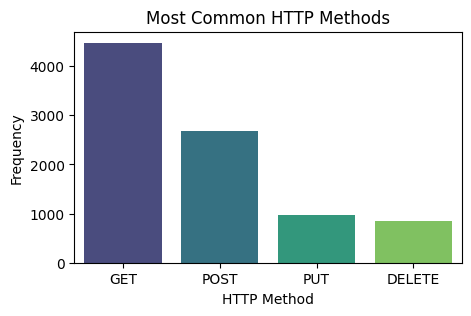

In [12]:
# Visualizing frequency of HTTP methods
plt.figure(figsize=(5, 3))
sns.barplot(x=method_counts.index, y=method_counts.values, palette='viridis')
plt.xlabel('HTTP Method')
plt.ylabel('Frequency')
plt.title('Most Common HTTP Methods')
plt.show()

In [13]:
# b. HTTP Status Code Distribution

status_counts = logs_df['status'].value_counts()
print(status_counts)

status
200    5394
301    1831
404     926
500     849
Name: count, dtype: int64


* 200 OK: Request succeeded; server responded.
* 404 Not Found: Resource not found; server couldn’t locate the requested data.
* 301 Moved Permanently: Resource permanently moved; redirection needed.
* 500 Internal Server Error: Server error; unexpected issue occurred.

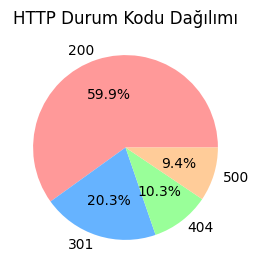

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('HTTP Durum Kodu Dağılımı')
plt.show()

In [15]:
logs_df.shape

(9000, 6)

In [16]:
# c. Most Frequently Seen URLs

url_counts = logs_df['url'].value_counts()
print(url_counts.head())

url
/home        1067
/products    1043
/contact     1023
/about       1020
/login        985
Name: count, dtype: int64


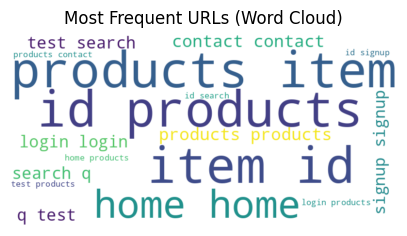

In [17]:
from wordcloud import WordCloud

top_urls = url_counts.head(50)  
url_text = ' '.join([f"{url} " * count for url, count in top_urls.items()])  

# Creating Word Cloud
plt.figure(figsize=(5, 3))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(url_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent URLs (Word Cloud)')
plt.show()

In [18]:
#d. Analysis of Traffic Size

size_summary = logs_df['size'].describe()
print(size_summary)

count    9000.000000
mean     2588.127222
std      1387.331417
min       200.000000
25%      1382.000000
50%      2556.500000
75%      3793.000000
max      5000.000000
Name: size, dtype: float64


/tmp/ipykernel_33/564568052.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(logs_df['size'], shade=True, color='red')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


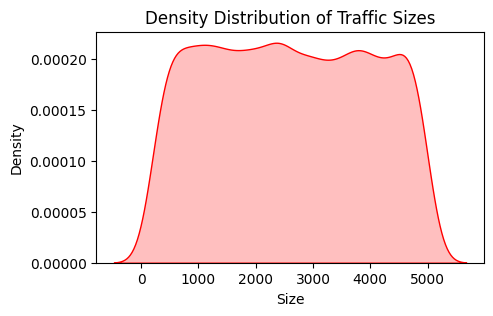

In [19]:
plt.figure(figsize=(5, 3))
sns.kdeplot(logs_df['size'], shade=True, color='red')
plt.title('Density Distribution of Traffic Sizes')
plt.xlabel('Size')
plt.ylabel('Density')
plt.show()

In [20]:
# e. Analysing traffic density over time
traffic_over_time = logs_df.groupby(logs_df['timestamp'].dt.date)['size'].sum()

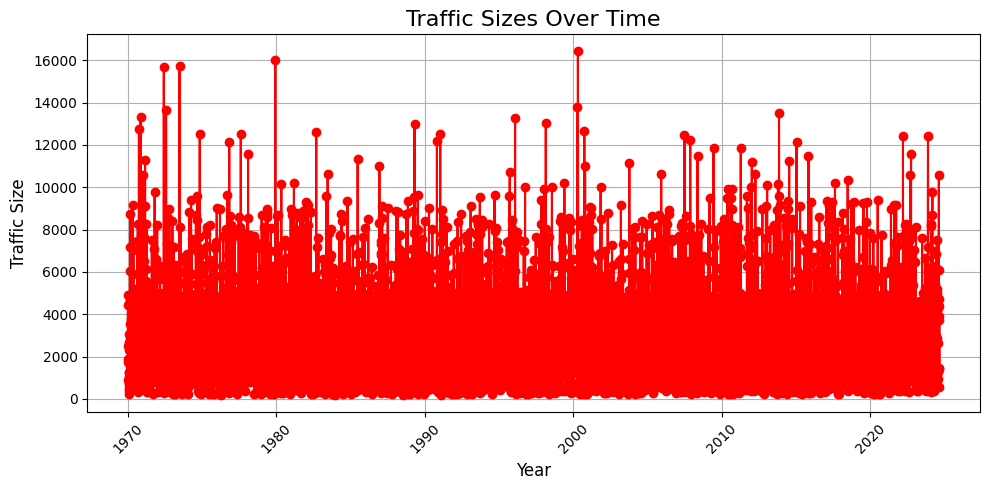

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(traffic_over_time.index, traffic_over_time.values, marker='o', linestyle='-', color='r')

plt.title('Traffic Sizes Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Traffic Size', fontsize=12)

plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()  
plt.show()

## 5. LLM Part

**We convert the df to a CSV file to make the operations easier.**

In [22]:
from io import StringIO

# StringIO object to capture the CSV output
csv_buffer = StringIO()

# Write DataFrame to the buffer
logs_df.to_csv(csv_buffer, index=False)

# Get the CSV string
logs_csv = csv_buffer.getvalue()

In [23]:
# length of the CSV string
len(logs_csv)

584011

In [24]:
logs_csv[0:100]

'ip,timestamp,method,url,status,size\n116.7.28.91,2005-03-02 07:02:39+00:00,DELETE,/login,200,1937\n121'

## 5.1 Text Splitters / Chunking
Next step is to do text splitting. The reason we do this because any LLM will have a token size limit. Thats why we need to reduce the big block of text into small of chunks.

Dil Modeli Performansını İyileştirmek:

Sorun: Büyük dil modelleri (LLM'ler), çok uzun metinler üzerinde çalışırken verimlilik kaybı yaşayabilir. Örneğin, bir modelin aynı anda çok büyük bir metni işlemeye çalışması, belleği zorlayabilir ve modelin performansını düşürebilir.
Çözüm: Chunking, metni daha kısa bölümlere ayırarak modelin her bir parçayı bağımsız olarak işlemesini sağlar. Bu da modelin daha hızlı ve daha verimli çalışmasına olanak tanır. Örneğin, bir soru-cevap sistemi geliştirilirken, modelin her bir chunk üzerinde ayrı ayrı cevaplar üretmesi daha etkin olabilir.

In [25]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 779.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 7.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.9/393.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: orjson
    Found existing installation: orjson 3.9.10
    Uninstalling orjson-3.9.10:
      Successfully uninstalled orjson-3.9.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.6.1

**5.1.1 Manuel Splitting**

In [26]:
words = logs_csv.split(" ")
len(words)

9001

In [27]:
chunks = []

s = ""
for word in words:
    s += word + " "
    if len(s)>200:
        chunks.append(s)
        s = ""
        
chunks.append(s)

In [28]:
chunks[:3]

['ip,timestamp,method,url,status,size\n116.7.28.91,2005-03-02 07:02:39+00:00,DELETE,/login,200,1937\n121.130.221.222,1997-04-29 18:01:02+00:00,GET,/search?q=test,200,1234\n49.96.48.87,1977-04-28 20:56:04+00:00,POST,/products,301,2227\n185.4.159.242,1988-09-18 ',
 '18:32:50+00:00,GET,/contact,200,1007\n84.65.175.7,1979-04-08 06:01:04+00:00,GET,/signup,200,4966\n156.227.152.73,1977-02-10 10:21:53+00:00,GET,/about,200,609\n43.160.134.238,1992-03-10 20:51:45+00:00,GET,/signup,301,909\n110.223.136.179,2017-04-03 ',
 '16:10:56+00:00,GET,/products/item?id=2,200,2131\n86.131.2.15,1980-02-07 04:45:48+00:00,GET,/contact,404,1053\n198.156.117.140,1972-07-31 00:09:30+00:00,GET,/signup,301,3887\n15.136.177.39,2016-04-24 20:43:38+00:00,POST,/search?q=test,200,3294\n118.70.187.223,1982-09-19 ']

Writing a for loop for this task can be tedious and prone to errors. Fortunately, LangChain offers a straightforward API through various text splitter classes, eliminating the need for manual effort.

**5.1.2 Using Text Splitter Classes from Langchain**

In [29]:
from langchain.text_splitter import CharacterTextSplitter

splitter = CharacterTextSplitter(
    separator = "\n", # "/n" means each line can be a chunk. Here we have just one seperator.
    chunk_size=100,
    chunk_overlap=20
)

In [30]:
chunks = splitter.split_text(logs_csv)
len(chunks)  # We have 9000 chunks. 

9000

In [31]:
# Convert Chunks to a new DataFrame
chunks_df = pd.DataFrame({'chunk_text': chunks})

In [32]:
# Look at individual chunk lengths and their content
for chunk in chunks[:2]:
    print(str(len(chunk)) + " " + chunk)

96 ip,timestamp,method,url,status,size
116.7.28.91,2005-03-02 07:02:39+00:00,DELETE,/login,200,1937
69 121.130.221.222,1997-04-29 18:01:02+00:00,GET,/search?q=test,200,1234


## 5.2 Vector Database

In [33]:
#Install Packages
!pip install faiss-cpu
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 49.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 1.7 MB/s eta 0:00:00a 0:00:01m


**FAISS Vector Database**

In [34]:
# import necessary libraries
import pandas as pd
pd.set_option('display.max_colwidth', 100)

#### Step 1 : Create source embeddings for the text column

In [35]:
from sentence_transformers import SentenceTransformer

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-08-22 20:40:05.621594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 20:40:05.621715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 20:40:05.904913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [36]:
chunks_df.head()

,chunk_text
0,"ip,timestamp,method,url,status,size\n116.7.28.91,2005-03-02 07:02:39+00:00,DELETE,/login,200,1937"
1,"121.130.221.222,1997-04-29 18:01:02+00:00,GET,/search?q=test,200,1234"
2,"49.96.48.87,1977-04-28 20:56:04+00:00,POST,/products,301,2227"
3,"185.4.159.242,1988-09-18 18:32:50+00:00,GET,/contact,200,1007"
4,"84.65.175.7,1979-04-08 06:01:04+00:00,GET,/signup,200,4966"


In [37]:
header = 'ip,timestamp,method,url,status,size'

def remove_header_from_chunk(chunk_text):
    if chunk_text.startswith(header):
        return chunk_text[len(header) + 1:]  # +1 for the newline character
    return chunk_text

chunks_df['chunk_text'] = chunks_df['chunk_text'].apply(remove_header_from_chunk)

chunks_df.head()

,chunk_text
0,"116.7.28.91,2005-03-02 07:02:39+00:00,DELETE,/login,200,1937"
1,"121.130.221.222,1997-04-29 18:01:02+00:00,GET,/search?q=test,200,1234"
2,"49.96.48.87,1977-04-28 20:56:04+00:00,POST,/products,301,2227"
3,"185.4.159.242,1988-09-18 18:32:50+00:00,GET,/contact,200,1007"
4,"84.65.175.7,1979-04-08 06:01:04+00:00,GET,/signup,200,4966"


In [38]:
chunks_df.shape

(9000, 1)

In [39]:
encoder = SentenceTransformer("all-mpnet-base-v2") # model
vectors = encoder.encode(chunks_df['chunk_text'].tolist())  

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

In [40]:
vectors.shape

(9000, 768)

We have 9000 vectors and size of each vector is 768.

In [41]:
vectors

array([[ 0.05775984, -0.04581011,  0.00212084, ...,  0.00531383,
         0.01452359,  0.00998288],
       [ 0.01017232,  0.0208998 , -0.03601826, ...,  0.01478176,
        -0.01466982, -0.0211644 ],
       [ 0.02903612, -0.02572479, -0.02904639, ..., -0.00916641,
        -0.02514808, -0.04766224],
       ...,
       [ 0.02934252, -0.05472207, -0.02176114, ..., -0.02836666,
         0.00055707, -0.03419057],
       [ 0.01881234, -0.00716407, -0.02169483, ...,  0.03516499,
        -0.02625794, -0.04912909],
       [ 0.01185127,  0.01319298, -0.04513782, ...,  0.00362968,
        -0.03076421, -0.05163778]], dtype=float32)

In [42]:
dim = vectors.shape[1]
dim # This value refers to the length (or change) of the vectors, and this dimension is the digital representation of the vectors that can be enlarged.

768

#### Step 2 : Build a FAISS Index for vectors


In [43]:
import faiss

index = faiss.IndexFlatL2(dim) # it is just creating similar to database index it is just creating an index that allows us to do faster search.

#### Step 3 : Normalize the source vectors (as we are using L2 distance to measure similarity) and add to the index

In [44]:
index.add(vectors) # in empty index we add vectors.

In this code block I add a vector array to an index structure. Vectors are often added to a database or index structure (for example, a vector-based search engine such as FAISS) so that similarity searches can be performed later.

In [45]:
index

<faiss.swigfaiss_avx512.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7e6f886deeb0> >

#### Step 4 : Encode search text using same encoder and normalize the output vector

In [46]:
search_query = "Which log entries contain a DELETE request for the /contact URL?"
vec = encoder.encode(search_query)
vec.shape
#1d array

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)

In [47]:
#vec

In [48]:
# with using numpy we translated 1d to 2d array.
import numpy as np
svec = np.array(vec).reshape(1,-1)
svec.shape

(1, 768)

In [49]:
#svec

In [50]:
#This expects 2d array.
index.search(svec, k = 2) # svec = supply search vector
# k asks: How many similar vectors do you want? This is like kth nearest neighbor.
# I write 2 so I want 2 similar vector.

(array([[0.6551521, 0.6664225]], dtype=float32), array([[8793, 1343]]))

#### Step 5: Search for similar vector in the FAISS index created

In [51]:
distances, I = index.search(svec, k=2)

In [52]:
import numpy as np

print("FAISS indices:", I)

# Extract indices from FAISS result
indices = I[0] 

# Be sure indices are within bounds. Because there were happened some out of bound error.
valid_indices = [i for i in indices if i < chunks_df.shape[0]]
print("Valid indices:", valid_indices)

# Retrieve rows from DataFrame using valid indices
try:
    results = chunks_df.iloc[valid_indices]
    print(results)
except IndexError as e:
    print(f"Index error: {e}")

FAISS indices: [[8793 1343]]
Valid indices: [8793, 1343]
                                                             chunk_text
8793  153.118.123.23,2007-06-18 01:38:43+00:00,DELETE,/contact,404,1652
1343     92.25.94.28,2010-05-17 05:13:54+00:00,DELETE,/contact,404,2834


## 5.3 RAG Architecture
RAG (Retrieval-Augmented Generation) is a type of model that combines information retrieval and text generation techniques to improve the quality of language model outputs.

In [53]:
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import pipeline

In [54]:
# LLM for text generation (e.g., BART, T5)
model_name = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Sentence Transformer for semantic similarity (e.g., all-mpnet-base-v2)
#encoder = SentenceTransformer("all-mpnet-base-v2")

# Adjust batch size for encoding larger datasets
batch_size = 128  # Experiment with batch sizes for performance

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [55]:
# Method Version of vectorizing

def encode_data(data, encoder, batch_size=batch_size):
  encoded_data = []
  for i in range(0, len(data), batch_size):
    batch = data.iloc[i:i+batch_size]["chunk_text"].tolist()
    encoded_batch = encoder.encode(batch)
    encoded_data.extend(encoded_batch)
  return np.array(encoded_data)

encoded_data = encode_data(chunks_df.copy(), encoder, batch_size=batch_size)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [56]:
dim = encoded_data.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(encoded_data)

**RETRIEVAL**
Retrieval: Retrieves relevant information or documents from a large data pool.

In [57]:
def retrieve(search_query, encoder, index, k=2):
  """
  Retrieves similar data points based on the search query.
  """
  vec = encoder.encode(search_query)
  svec = np.array(vec).reshape(1, -1)
  distances, I = index.search(svec, k=k)
  return I[0]  

In [58]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "t5-small"  
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def augment(data_point, model, tokenizer):
    """
    Augments the retrieved data point using the T5 model.
    This step can be used to generate additional text or variations.
    """
    prompt = f"paraphrase: {data_point}"

    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    output = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
    augmented_data_point = tokenizer.decode(output[0], skip_special_tokens=True)

    return augmented_data_point


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [59]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "t5-small"  
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def generate(data_point, model, tokenizer):
    """
    Generates new text based on the retrieved data point using the T5 model.
    This step can be used to create different responses or outputs.
    """
    prompt = f"paraphrase: {data_point}"

    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    output = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    return generated_text

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [60]:
augmented_results = [augment(result, model, tokenizer) for result in results]

In [61]:

search_query = "Which log entries date are before 2003?"

indices = retrieve(search_query, encoder, index)

valid_indices = [i for i in indices if i < chunks_df.shape[0]]

try:
    results = chunks_df.iloc[valid_indices]
    print("Retrieved Data Points:")
    print(results)
    
    augmented_results = [augment(row['chunk_text'], model, tokenizer) for _, row in results.iterrows()]
    print("Augmented Results:")
    print(augmented_results)

    generated_texts = [generate(row['chunk_text'], model, tokenizer) for _, row in results.iterrows()]
    print("Generated Texts:")
    print(generated_texts)

except IndexError as e:
    print(f"Index error: {e}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved Data Points:
                                                                   chunk_text
7875       154.9.16.194,1995-12-13 21:29:12+00:00,GET,/search?q=test,200,1987
8531  101.94.245.168,1996-03-16 22:16:41+00:00,DELETE,/search?q=test,200,1993
Augmented Results:
['paraphrase: 154.9.16.194,1995-12-13 21:29:12+00:00,GET,/search?q=test,200,1987', 'paraphrase: 101.94.245.168,1996-03-16 22:16:41+00:00,DELETE,/search?q=test,200,1993']
Generated Texts:
['paraphrase: 154.9.16.194,1995-12-13 21:29:12+00:00,GET,/search?q=test,200,1987', 'paraphrase: 101.94.245.168,1996-03-16 22:16:41+00:00,DELETE,/search?q=test,200,1993']


In [62]:
# Kullanıcıdan soru al
user_query = input("Lütfen bir soru sor: ")

# Arama yap ve yanıtı üret
indices = search(user_query)
response = generate_response(user_query, indices)

print(response)

Lütfen bir soru sorun:  Which log entries date are before 2003?


NameError: name 'search' is not defined